# Import necessary packages

In [29]:
#!pip install git+https://github.com/fspinna/borf.git@xai-improvements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline

plt.style.use('default')

# Load single cell data

In [2]:
data = pd.read_csv("temporal_data_with_patient_ready_normalized_full_genes.csv", index_col=0)
data = data.dropna(axis=0)

In [3]:
# remove rows containing only zeros
#data = data.loc[(data.iloc[:, 1:] != 0).any(axis=1)]

data.shape

(5488056, 6)

In [4]:
# remove a layer of complexity by averaging the data across patients for each gene and celltype
data.index = data.index.str.split('_').map(lambda x: (x[0], x[-1]))
data.index = pd.MultiIndex.from_tuples(data.index, names=["gene", "celltype"])
data_avg = data.groupby(level=["gene", "celltype"]).mean()

# fix the index
data_avg = data_avg.reset_index()
data_avg["gene_celltype"] = data_avg["gene"] + "_" + data_avg["celltype"]
data_avg = data_avg.set_index("gene_celltype").drop(columns=["gene", "celltype"])

print(data_avg.head())


                                d0        d1        d2        d5        d9  \
gene_celltype                                                                
A1BG_Bcells               0.196337  0.235422  0.229986  0.329739  0.465127   
A1BG_CD4cytotoxicT        0.000000  0.265965  0.218069  0.269721  0.445299   
A1BG_CD4memoryT           0.211437  0.208521  0.167145  0.225112  0.305198   
A1BG_CD4memoryactivatedT  0.223909  0.211382  0.183420  0.380808  0.379326   
A1BG_CD4naiveT            0.178656  0.179129  0.212789  0.095340  0.089639   

                               d15  
gene_celltype                       
A1BG_Bcells               0.365523  
A1BG_CD4cytotoxicT        0.266964  
A1BG_CD4memoryT           0.187713  
A1BG_CD4memoryactivatedT  0.353488  
A1BG_CD4naiveT            0.111972  


In [5]:
# load genes in PPI
ppi_genes = pd.read_csv("string_interactions_short.tsv", sep="\t")
#merge node1 and node2 columns, and find unique genes
ppi_genes = pd.concat([ppi_genes["node1"], ppi_genes["node2"]]).unique()

len(ppi_genes)



459

In [6]:
# filter data to only include genes in PPI
data_avg = data_avg.loc[data_avg.index.str.split('_').str[0].isin(ppi_genes)]
data_avg.shape

(9387, 6)

In [7]:
data = data_avg

columns = data.columns
genes = np.array([name.split("_")[0] for name in list(data.index)])
cells = np.array([name.split("_")[1] for name in list(data.index)])

enc_genes = LabelEncoder()
enc_cells = LabelEncoder()

enc_genes.fit(genes)
enc_cells.fit(cells)

X = data.values[:, np.newaxis, :]

y_genes = enc_genes.transform(genes)
y_cells = enc_cells.transform(cells)

X.shape, y_genes.shape, y_cells.shape, genes.shape, cells.shape

((9387, 1, 6), (9387,), (9387,), (9387,), (9387,))

In [8]:
len(np.unique(genes))

447

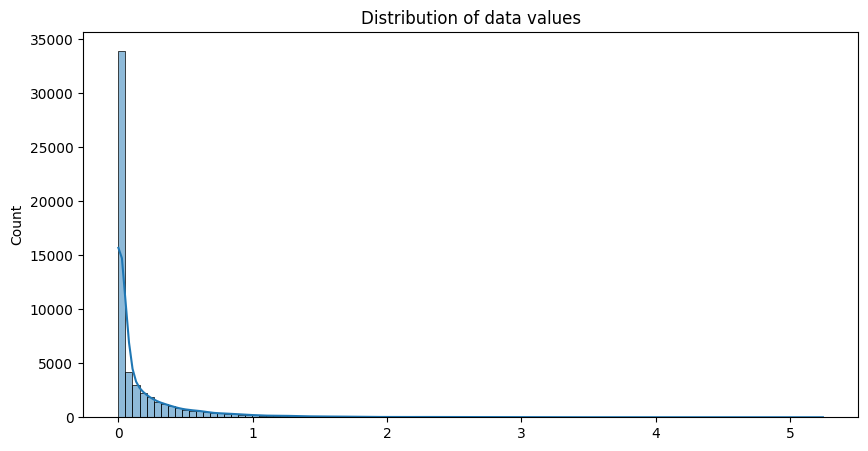

In [9]:
# plot barplot of data values to see its distribution
plt.figure(figsize=(10, 5))
sns.histplot(data.values.flatten(), bins=100, kde=True)
plt.title("Distribution of data values")
plt.show()

## BORF

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier
import numpy as np
from fast_borf import BorfBuilder
from fast_borf.pipeline.zero_columns_remover import ZeroColumnsRemover
from fast_borf.pipeline.reshaper import ReshapeTo2D
from fast_borf.pipeline.to_scipy import ToScipySparse
from fast_borf.xai.mapping import BagOfReceptiveFields
from constants import CUSTOM_CONFIG_A3, CUSTOM_CONFIG_A3_NO_DILATION, CUSTOM_CONFIG_A3_NO_DILATION_WINDOW_SIZE_2_3_4

In [11]:
# Setup the BORF builder
builder = BorfBuilder(
    n_jobs=-2, window_size_min_window_size=None, alphabets_min_symbols=None, alphabets_max_symbols=None, min_window_to_signal_std_ratio=0.15, configs=CUSTOM_CONFIG_A3_NO_DILATION_WINDOW_SIZE_2_3_4,
    pipeline_objects=[
        (ReshapeTo2D, dict(keep_unraveled_index=True)),
        (ZeroColumnsRemover, dict(axis=0)),
        (ToScipySparse, dict()),
        ],
)
borf = builder.build(X)

In [12]:
builder.configs_

[{'window_size': 2,
  'stride': 1,
  'dilation': 1,
  'word_length': 2,
  'alphabet_size': 3},
 {'window_size': 3,
  'stride': 1,
  'dilation': 1,
  'word_length': 3,
  'alphabet_size': 3},
 {'window_size': 4,
  'stride': 1,
  'dilation': 1,
  'word_length': 2,
  'alphabet_size': 3},
 {'window_size': 4,
  'stride': 1,
  'dilation': 1,
  'word_length': 4,
  'alphabet_size': 3}]

In [13]:
%%time
X_transformed = borf.fit_transform(X)
X_transformed.shape

CPU times: user 171 ms, sys: 1.03 s, total: 1.2 s
Wall time: 5.57 s


(9387, 74)

In [14]:
X_transformed_sorted = X_transformed.toarray()[np.argsort(cells)]
X_transformed_sorted = X_transformed_sorted[:, np.argsort(X_transformed.toarray()[np.argsort(cells)].mean(axis=0).ravel())[::-1]]
X_transformed_sorted

array([[1, 2, 2, ..., 0, 0, 0],
       [4, 1, 0, ..., 0, 0, 0],
       [2, 2, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 2, 2, ..., 0, 0, 0],
       [4, 1, 0, ..., 0, 0, 0]])

In [15]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_transformed, y_genes)

DecisionTreeClassifier()

In [16]:
from sklearn.metrics import precision_score
accuracy = precision_score(y_genes, clf.predict(X_transformed.astype(float)), average='micro')
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.4516


In [17]:
# how many times higher is the accuracy compared to random guessing
accuracy / (1/len(np.unique(genes)))

201.85714285714286

In [18]:
np.unique(y_genes, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [19]:
# get all row indexes of X_transformed corresponding to one cell type
cell_type = "CIKcells"
cell_type_indexes = np.where(enc_cells.inverse_transform(y_cells) == cell_type)[0]
cell_type_indexes

array([  10,   31,   52,   73,   94,  115,  136,  157,  178,  199,  220,
        241,  262,  283,  304,  325,  346,  367,  388,  409,  430,  451,
        472,  493,  514,  535,  556,  577,  598,  619,  640,  661,  682,
        703,  724,  745,  766,  787,  808,  829,  850,  871,  892,  913,
        934,  955,  976,  997, 1018, 1039, 1060, 1081, 1102, 1123, 1144,
       1165, 1186, 1207, 1228, 1249, 1270, 1291, 1312, 1333, 1354, 1375,
       1396, 1417, 1438, 1459, 1480, 1501, 1522, 1543, 1564, 1585, 1606,
       1627, 1648, 1669, 1690, 1711, 1732, 1753, 1774, 1795, 1816, 1837,
       1858, 1879, 1900, 1921, 1942, 1963, 1984, 2005, 2026, 2047, 2068,
       2089, 2110, 2131, 2152, 2173, 2194, 2215, 2236, 2257, 2278, 2299,
       2320, 2341, 2362, 2383, 2404, 2425, 2446, 2467, 2488, 2509, 2530,
       2551, 2572, 2593, 2614, 2635, 2656, 2677, 2698, 2719, 2740, 2761,
       2782, 2803, 2824, 2845, 2866, 2887, 2908, 2929, 2950, 2971, 2992,
       3013, 3034, 3055, 3076, 3097, 3118, 3139, 31

In [20]:
X_transformed.toarray()[cell_type_indexes].shape

(447, 74)

In [21]:
np.unique(X_transformed.indices)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73], dtype=int32)

In [22]:
import fasttreeshap
shap_explainer = fasttreeshap.TreeExplainer(clf, algorithm = 'auto', n_jobs = -1)
shap_values = shap_explainer(X_transformed.toarray()[cell_type_indexes], check_additivity=True).values

In [23]:
enc_genes.classes_.astype(str)

array(['ADAR', 'AIM2', 'AKIRIN2', 'ALCAM', 'ALPK1', 'ANXA1', 'APOBEC3A',
       'APOBEC3B', 'APOBEC3C', 'APOBEC3F', 'APOBEC3G', 'APOBEC3H', 'ARG1',
       'ARG2', 'ARHGEF2', 'ATG5', 'AXL', 'B2M', 'BAG6', 'BCL10', 'BCL6',
       'BPIFB1', 'BST2', 'BTK', 'BTLA', 'BTN3A1', 'BTN3A2', 'BTN3A3',
       'C1QA', 'C1QB', 'C1QBP', 'C1QC', 'C1R', 'C1S', 'C2', 'C3', 'C4A',
       'C4B', 'C4BPA', 'C4BPB', 'C5', 'C6', 'C7', 'C8A', 'C8B', 'C8G',
       'C9', 'CADM1', 'CARD9', 'CASP4', 'CD14', 'CD160', 'CD177', 'CD180',
       'CD19', 'CD1A', 'CD1B', 'CD1C', 'CD1D', 'CD1E', 'CD209', 'CD244',
       'CD247', 'CD274', 'CD300A', 'CD300C', 'CD300E', 'CD300LB',
       'CD300LD', 'CD300LF', 'CD3D', 'CD3E', 'CD3G', 'CD4', 'CD40',
       'CD46', 'CD55', 'CD6', 'CD7', 'CD74', 'CD79A', 'CD79B', 'CD81',
       'CD84', 'CD86', 'CD8A', 'CD8B2', 'CFB', 'CFD', 'CFH', 'CFI', 'CFP',
       'CGAS', 'CHIA', 'CLEC10A', 'CLEC4A', 'CLEC4C', 'CLEC4D', 'CLEC4E',
       'CLEC4M', 'CLEC5A', 'CLEC6A', 'CLEC7A', 'CLU', 'CNPY3', 

In [24]:
# Aggregation methods
average = np.mean(abs(shap_values), axis=0)  # Shape: (74, 2000)
maximum = np.max(abs(shap_values), axis=0)   # Shape: (74, 2000)
summation = np.sum(abs(shap_values), axis=0) # Shape: (74, 2000)

average_df = pd.DataFrame(average, columns = enc_genes.classes_.astype(str))
print("Done with average")
maximum_df = pd.DataFrame(maximum, columns = enc_genes.classes_.astype(str))
print("Done with maximum")
summation_df = pd.DataFrame(summation, columns = enc_genes.classes_.astype(str))
print("Done with summation")

Done with average
Done with maximum
Done with summation


In [25]:
average_df.shape, maximum_df.shape, summation_df.shape

((74, 447), (74, 447), (74, 447))

In [26]:
# find max value in each column
max_average = average_df.max()
max_maximum = maximum_df.max()
max_summation = summation_df.max()

In [27]:
num_permutations = 100
for i in range(num_permutations):
  y_genes_perm = np.random.permutation(y_genes)
  model = DecisionTreeClassifier()
  model.fit(X_transformed, y_genes_perm)
  shap_explainer = fasttreeshap.TreeExplainer(model, algorithm = 'auto', n_jobs = -1)
  shap_values_perm = shap_explainer(X_transformed.toarray()[cell_type_indexes], check_additivity=False).values
  average_perm = np.mean(abs(shap_values_perm), axis=0)
  if i == 0:
    average_perm_list = average_perm[np.newaxis, :]
  else:
    average_perm_list = np.vstack((average_perm_list, average_perm[np.newaxis, :]))

# Calculate p-values
p_values = np.mean(average_perm_list >= average, axis=0)





In [28]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import fasttreeshap
from joblib import Parallel, delayed

num_permutations = 1000
num_jobs = -1  # Use all CPU cores

# Convert X_transformed to array once (avoid repeated .toarray() calls)
X_transformed_arr = X_transformed.toarray()[cell_type_indexes]

# Function to compute one permutation
def compute_permutation(i):
    y_genes_perm = np.random.permutation(y_genes)  # Shuffle labels
    model = DecisionTreeClassifier()
    model.fit(X_transformed, y_genes_perm)

    shap_explainer = fasttreeshap.TreeExplainer(model, algorithm='auto', n_jobs=-1)
    shap_values_perm = shap_explainer(X_transformed_arr, check_additivity=False).values
    
    return np.einsum('ijk->jk', np.abs(shap_values_perm)) / shap_values_perm.shape[0]  # Fast mean computation

# Run permutations in parallel
average_perm_list = np.array(Parallel(n_jobs=num_jobs)(delayed(compute_permutation)(i) for i in range(num_permutations)))

# Calculate p-values (element-wise comparison across all permutations)
p_values = pd.DataFrame(np.mean(average_perm_list >= average, axis=0))



In [30]:
p_values, np.min(p_values), np.max(p_values)

(      0      1      2      3      4      5      6      7      8      9    ...  \
 0   1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  ...   
 1   0.505  0.483  0.959  0.747  0.863  0.074  0.208  0.123  0.314  0.612  ...   
 2   0.863  0.618  0.240  0.403  0.123  0.179  0.631  0.667  0.502  0.878  ...   
 3   0.176  0.109  0.558  0.144  0.059  0.211  0.216  0.089  0.543  0.645  ...   
 4   0.008  0.005  0.006  0.004  0.001  0.001  0.004  0.015  0.005  0.009  ...   
 ..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
 69  0.187  0.445  0.124  0.098  0.033  0.095  0.995  0.612  0.778  0.631  ...   
 70  0.771  0.338  0.031  1.000  0.117  0.135  1.000  1.000  0.389  0.092  ...   
 71  1.000  0.115  1.000  1.000  0.032  0.024  1.000  1.000  1.000  0.156  ...   
 72  0.107  0.566  0.039  0.480  0.341  0.058  0.420  1.000  0.320  0.081  ...   
 73  1.000  1.000  0.349  1.000  1.000  1.000  0.310  1.000  0.027  1.000  ...   
 
       437    

In [59]:
# fix shap based on pvalues
shap_values_pval_penalized = abs(average * (pd.DataFrame(1-p_values)))
shap_values_pval_penalized.columns = enc_genes.classes_.astype(str)
shap_values_pval_penalized

,ADAR,AIM2,AKIRIN2,ALCAM,ALPK1,ANXA1,APOBEC3A,APOBEC3B,APOBEC3C,APOBEC3F,...,XRCC5,XRCC6,YTHDF1,YTHDF2,ZAP70,ZBP1,ZC3H12A,ZC3HAV1,ZCCHC3,ZNF683
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
1,0.000254,0.000274,0.000006,0.000073,0.000028,0.001358,7.785676e-04,0.001102,0.000496,0.000158,...,7.497993e-04,0.000022,0.000023,0.000268,0.000668,0.000329,0.001140,8.337084e-04,0.000183,5.285658e-04
2,0.000037,0.000192,0.000778,0.000425,0.001155,0.000979,1.857357e-04,0.000146,0.000288,0.000031,...,8.562202e-04,0.000058,0.000061,0.000427,0.000016,0.000344,0.000104,3.406948e-05,0.000589,6.019023e-04
3,0.000816,0.001112,0.000200,0.000893,0.001440,0.000747,7.195561e-04,0.001182,0.000208,0.000132,...,5.322606e-04,0.000585,0.000628,0.000232,0.000386,0.000807,0.001137,1.269456e-04,0.001605,7.169123e-04
4,0.000271,0.000429,0.000387,0.000417,0.000804,0.001196,3.454323e-04,0.000176,0.000428,0.000293,...,3.374037e-04,0.000265,0.000365,0.000336,0.000281,0.000787,0.000471,1.313867e-03,0.000461,6.514670e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.000325,0.000115,0.000455,0.000523,0.000924,0.000503,7.931500e-09,0.000053,0.000019,0.000048,...,1.079105e-04,0.000042,0.000384,0.000006,0.000027,0.000073,0.000021,4.157814e-05,0.000108,9.053268e-07
70,0.000001,0.000060,0.000941,0.000000,0.000276,0.000220,0.000000e+00,0.000000,0.000043,0.000426,...,0.000000e+00,0.000000,0.000000,0.000024,0.000000,0.000000,0.000384,3.692103e-04,0.000000,0.000000e+00
71,0.000000,0.000003,0.000000,0.000000,0.000026,0.000023,0.000000e+00,0.000000,0.000000,0.000002,...,0.000000e+00,0.000000,0.000000,0.000004,0.000000,0.000073,0.000000,6.150055e-07,0.000024,0.000000e+00
72,0.000206,0.000027,0.000425,0.000039,0.000071,0.000311,5.364537e-05,0.000000,0.000086,0.000269,...,7.955744e-04,0.000041,0.000082,0.000115,0.000010,0.000002,0.000006,8.541143e-05,0.000086,2.499002e-06


In [60]:
shap_values_pval_penalized.max()

ADAR       0.001042
AIM2       0.001112
AKIRIN2    0.002752
ALCAM      0.001598
ALPK1      0.002963
             ...   
ZBP1       0.000877
ZC3H12A    0.001272
ZC3HAV1    0.001402
ZCCHC3     0.001662
ZNF683     0.003800
Length: 447, dtype: float64

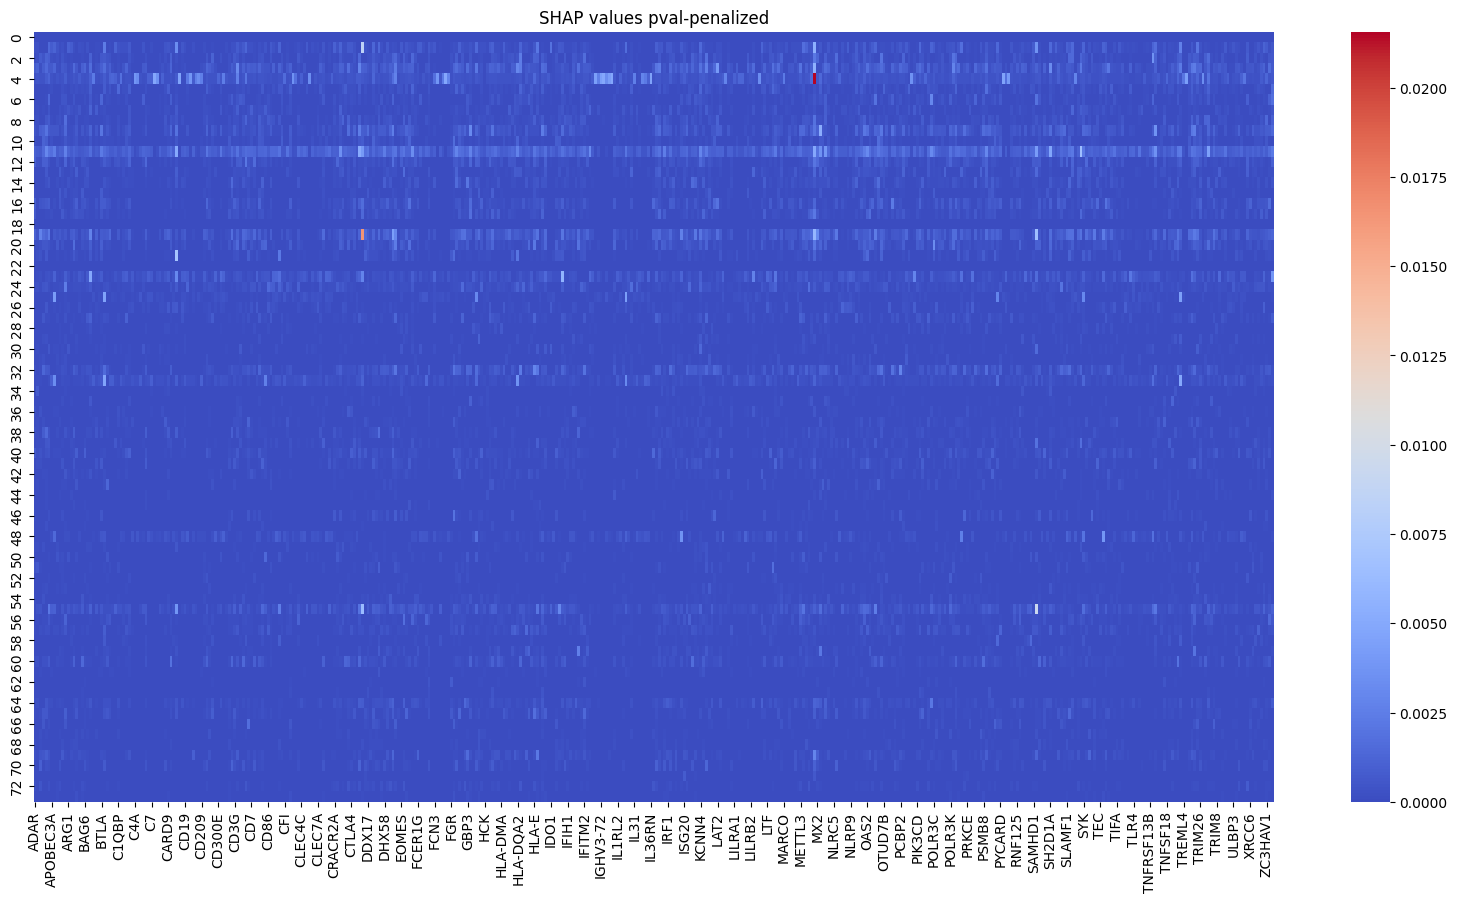

In [61]:
# make heatmap o fthe p-values
plt.figure(figsize=(20, 10))
sns.heatmap(shap_values_pval_penalized, cmap="coolwarm")
plt.title("SHAP values pval-penalized")
plt.show()

In [61]:
# create folder with shap values
import os
if not os.path.exists("shap_values"):
    os.makedirs("shap_values")

In [62]:
shap_values_pval_penalized.to_csv("shap_values/shap_values_CIK_cells_pvalpenalized.csv", index=False)

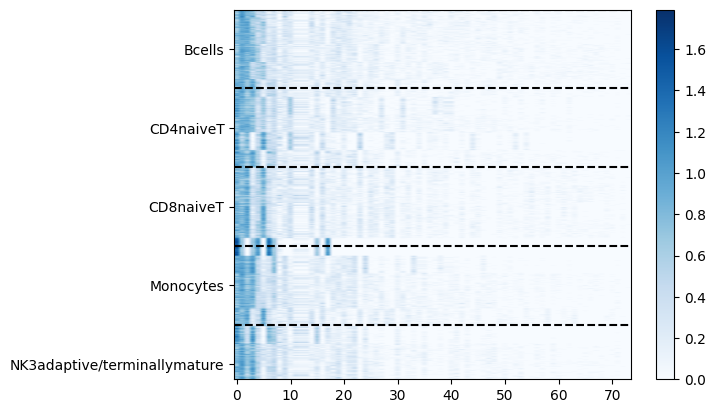

In [63]:

plt.imshow(np.log1p(X_transformed_sorted), cmap="Blues", aspect="auto")

plt.gca().set_yticks(np.arange(0, len(cells), 2000)+1000)
plt.gca().set_yticklabels(cells[np.argsort(cells)][::2000])

for i in range(0, len(cells), 2000):
    plt.axhline(y=i, color='k', linestyle='--')
plt.colorbar()

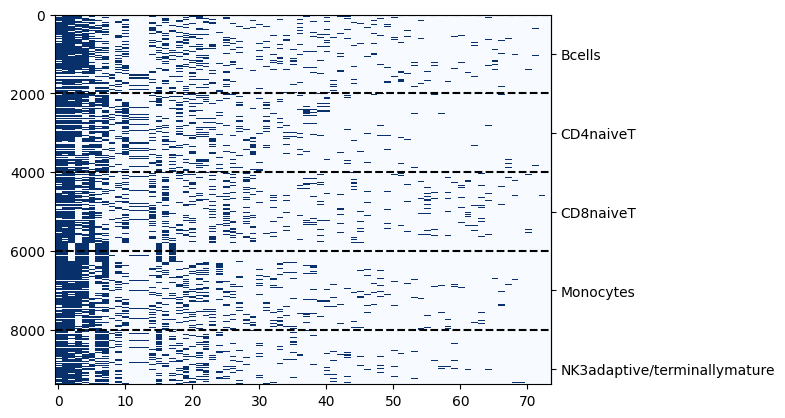

In [64]:
plt.imshow((X_transformed_sorted>0)*1, cmap="Blues", aspect="auto", interpolation="none")

# plt.axhline(y=i, color='k', linestyle='--')
secax = plt.gca().secondary_yaxis('right')  # Adds a secondary x-axis at the top
secax.set_yticks(np.arange(0, len(cells), 2000)+1000)  # Set ticks every 2000
secax.set_yticklabels(cells[np.argsort(cells)][::2000])

for i in range(0, len(cells), 2000):
    plt.axhline(y=i, color='k', linestyle='--')
# plt.xscale("log")

In [65]:
mapper = BagOfReceptiveFields(borf)
mapper.build(X)

unsafe cast from int64 to uint64. Precision may be lost.


In [66]:
mapper.mapping.shape

(74, 3)

In [67]:
from matplotlib.backends.backend_pdf import PdfPages

# Create a PDF file
with PdfPages('mappings.pdf') as pdf:
  for i in range(70):
    plt.figure()
    plt.plot(mapper[i].word_array, marker="o")
    plt.title(f'Mapping row_{i}')
    pdf.savefig()  # Save the current figure into the PDF
    plt.close()  # Close the figure to free memory

In [68]:
mapper[i].alignments[0]
mapper[i].mappings[0]

array([], shape=(0, 4, 1), dtype=int64)

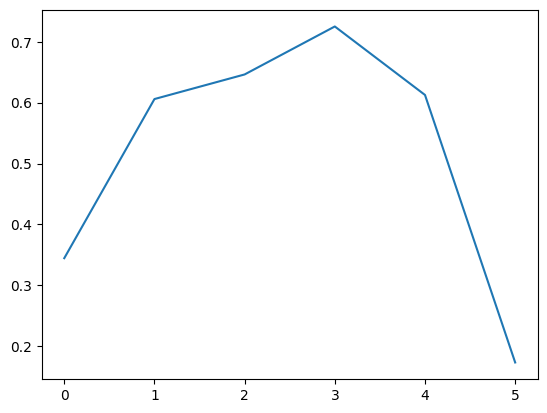

In [69]:

plt.plot(X[0, 0])
plt.plot(mapper[i].alignments[0].ravel(), mapper[i].mappings[0].ravel() )

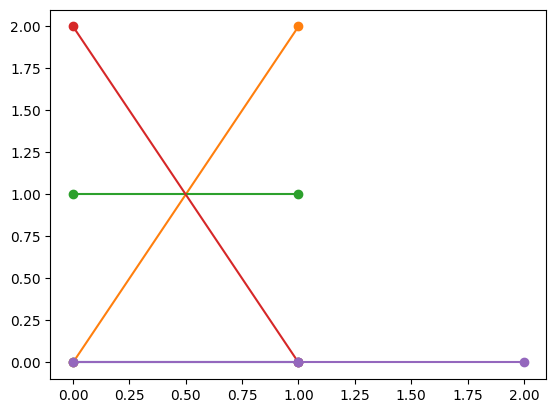

In [70]:
for i in range(5):
    plt.plot(mapper[i].word_array, marker="o")